# Подключение библиотеки

In [1]:
import os
import csv
import time
import uuid
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Метрики
from sklearn.metrics import mean_squared_error

# Нейросети
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim

# Импорт и анализ данных

In [2]:
try:
    df = pd.read_csv('Amp_C_train.txt')
except:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            
    df = pd.read_csv(os.path.join(dirname, filename))

##### Рассмотрим содержимое датасет

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172032 entries, 0 to 172031
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    172032 non-null  float64
 1   Input   172032 non-null  object 
 2   Output  172032 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


# Машинное обучение Complex Time Delay Recurrent Neural Network (CTDRNN)

In [4]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is not available. Running on CPU.


/home/redalexdad/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


#### Инициализация класса модели

In [19]:
class CTDRNN:
    def __init__(self, df, input_size:int, output_size:int, p:int, q:int, batch_size:int=1024, learning_rate:float=1e-4, epochs:int=10, hidden_layers:np.ndarray=[64, 128, 128, 64], dropout:float=0.5, device:str=None):
        # Преобразуем данные
        self.df = self.prepare_data(df)
        self.p = p
        self.q = q
        self.device = self.get_device(device)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers

        self.history = {"epoch": [], "rmse": []}  # История обучения
        # Генерация уникального ID при создании экземпляра класса
        self.model_id = str(uuid.uuid4())
        
        # Подготовка данных
        self.X_combined, self.Y_combined = self.create_time_delays_with_feedback(df, p, q, input_size, batch_size)
        
        # Обновление индекса
        time_index = self.df.index.values[max(p, q):len(self.X_combined) + max(p, q)]
        # Создание TensorDataset с обновленным индексом
        self.dataset = TensorDataset(
            torch.tensor(time_index, dtype=torch.float32), 
            torch.tensor(self.X_combined, dtype=torch.float32).unsqueeze(1), 
            torch.tensor(self.Y_combined, dtype=torch.float32)
        )
        self.train_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, pin_memory=True)
        
        # Инициализация модели
        self.model = self.CTDRNN_Model(input_size, hidden_layers, output_size, dropout).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    
    class CTDRNN_Model(nn.Module):
        def __init__(self, input_size:int, hidden_layers:np.ndarray, output_size:int, dropout:float=0.5):
            super().__init__()
            num_layers = hidden_layers.__len__()
            
            # LSTM слой
            self.lstm = nn.LSTM(
                input_size=input_size, 
                hidden_size=hidden_layers[0], 
                num_layers=num_layers, 
                batch_first=True,
                bidirectional=True, 
                dropout=dropout
            )

            # Динамическое создание полносвязных слоев
            self.fcs = nn.ModuleList()
            self.layer_norms = nn.ModuleList()
            input_dim = hidden_layers[0] * 2  + 1 # Учитываем bidirectional и временной индекс t
            for i in range(1, len(hidden_layers)):
                self.fcs.append(nn.Linear(input_dim, hidden_layers[i]))
                self.layer_norms.append(nn.LayerNorm(hidden_layers[i]))  # Инициализируем LayerNorm с правильным размером
                input_dim = hidden_layers[i]  # Для следующего слоя

            # Финальный выходной слой
            self.fc_out = nn.Linear(hidden_layers[-1], output_size)
            
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.3)
        
        def forward(self, x:torch.Tensor, t:torch.Tensor):
            # Проход через LSTM
            lstm_out, _ = self.lstm(x)
            x = lstm_out[:, -1, :]  # Берем последний временной шаг для каждого батча

            # Добавляем t как дополнительный признак
            t = t.unsqueeze(1)  # Добавляем дополнительное измерение, если нужно
            x = torch.cat((x, t), dim=1)  # Объединяем t с основными данными

            # Проход через динамически созданные полносвязные слои
            for fc, ln in zip(self.fcs, self.layer_norms):
                x = self.relu(fc(x))
                x = ln(x)  # Применяем заранее инициализированный LayerNorm
                x = self.dropout(x)
            
            # Финальный выход
            out = self.fc_out(x)
            return out

    @staticmethod
    def get_device(select:str=None):
        """
        Получает устройство для вычислений (CPU или GPU).

        Args:
            select (str, optional): Выбор устройства ('cpu', 'gpu' или 'cuda'). По умолчанию None.

        Returns:
            torch.device: Устройство для выполнения вычислений.
        """
        if select is None or select == 'gpu' or select == 'cuda':
            if torch.cuda.is_available():
                # print('Using GPU (CUDA)')
                return torch.device('cuda')
            else:
                # print("CUDA not available, falling back to CPU.")
                return torch.device('cpu')
        # CPU
        else:
            # print('Using CPU')
            return torch.device('cpu')

    @staticmethod
    def prepare_data(df):
        """
        Преобразует исходные данные в нужный формат.

        Args:
            df (pd.DataFrame): Входные данные с колонками 'Input', 'Output' и 'Time'.

        Returns:
            pd.DataFrame: Обработанный DataFrame с раздельными вещественными и мнимыми частями.
        """
        # Приведение к нижнему регистру названия колонки
        df.columns = df.columns.str.lower()
        df['input'] = df['input'].apply(lambda x: complex(x))  # Преобразуем строки в комплексные числа
        df['output'] = df['output'].apply(lambda x: complex(x))
        df['input_real'] = df['input'].apply(lambda x: x.real)
        df['input_imag'] = df['input'].apply(lambda x: x.imag)
        df['output_real'] = df['output'].apply(lambda x: x.real)
        df['output_imag'] = df['output'].apply(lambda x: x.imag)
        df = df.drop(['input', 'output'], axis=1)
        df = df.set_index('time')  # Устанавливаем временной ряд как индекс
        return df


    @staticmethod
    def create_time_delays_with_feedback(df, p:int, q:int, input_size:int, batch_size:int):
        """
        Создает временные задержки с обратной связью с использованием apply.

        Args:
            df (pd.DataFrame): DataFrame, содержащий 'input_real', 'input_imag', 'output_real', 'output_imag'.
            p (int): Порядок задержки для входных данных.
            q (int): Порядок задержки для обратной связи.
            input_size (int): Размер входных данных (не используется в текущей реализации).
            batch_size (int): Размер пакета (не используется в текущей реализации).

        Returns:
            X_combine, Y_bicombine (np.array): Векторизованные входные и обратные задержки.
        """
        X_real, X_imag, Y_real, Y_imag = df['input_real'], df['input_imag'], df['output_real'], df['output_imag']
        
        # Используем np.array для векторизации данных
        X_real_arr = X_real.values
        X_imag_arr = X_imag.values
        Y_real_arr = Y_real.values
        Y_imag_arr = Y_imag.values

        # Входные задержки
        X_real_delays = np.lib.stride_tricks.sliding_window_view(X_real_arr, p+1)
        X_imag_delays = np.lib.stride_tricks.sliding_window_view(X_imag_arr, p+1)
        
        # Обратная связь
        Y_real_delays = np.lib.stride_tricks.sliding_window_view(Y_real_arr, q)
        Y_imag_delays = np.lib.stride_tricks.sliding_window_view(Y_imag_arr, q)

        # Приводим все массивы к одному размеру
        min_size = min(len(X_real_delays), len(Y_real_delays))
        X_real_delays = X_real_delays[-min_size:]
        X_imag_delays = X_imag_delays[-min_size:]
        Y_real_delays = Y_real_delays[-min_size:]
        Y_imag_delays = Y_imag_delays[-min_size:]

        # Комбинирование задержек
        X_combined = np.hstack([X_real_delays, X_imag_delays, Y_real_delays, Y_imag_delays])

        # Текущие значения выходных данных
        Y_combined = np.column_stack([Y_real_arr[max(p, q):], Y_imag_arr[max(p, q):]])

        return X_combined, Y_combined

    def train(self):
        """
        Обучает модель CTDRNN на заданных данных и сохраняет графики после каждой эпохи.
        """
        self.model.train()
    
        for epoch in range(self.epochs):
            running_loss = 0.0
            rmse_total = 0.0
            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs}", unit="batch")
    
            for batch_idx, (t, inputs, targets) in enumerate(progress_bar):
                t, inputs, targets = t.to(self.device), inputs.to(self.device), targets.to(self.device) # Перенос батчей на GPU
                self.optimizer.zero_grad()

                # Прямой проход
                outputs = self.model(inputs, t) # Передаем t в модель
                loss = self.criterion(outputs, targets)
                
                self.optimizer.zero_grad() # Обратное распространение и оптимизация
                rmse = torch.sqrt(loss)  # RMSE
                loss.backward()
                self.optimizer.step()
                
                rmse_total += rmse.item() # Рассчитываем RMSE
                progress_bar.set_postfix(rmse=f"{rmse:.6f}")
    
            avg_rmse = rmse_total / len(self.train_loader)
            
            # Сохраняем метрики в историю
            self.history["epoch"].append(epoch + 1)
            self.history["rmse"].append(avg_rmse)

            print(f"Epoch {epoch+1}/{self.epochs} completed with RMSE: {avg_rmse:.6f}")
    
        print("Training completed!")


    def evaluate(self, training:bool=False):
        """
        Оценка модели на обучающем наборе данных.

        Args:
            training (bool): Если True, оценка будет выполнена на обучающем наборе данных.
            
        Returns:
            tuple: Значения RMSE для реальных и мнимых частей, предсказанные значения.
        """     
        if not training: self.model.eval()
        true_values = []
        predicted_values = []
        times = []
    
        with torch.no_grad():
            for t, inputs, targets in self.train_loader:
                t, inputs, targets = t.to(self.device), inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs, t)
                true_values.append(targets.cpu().numpy())
                predicted_values.append(outputs.cpu().numpy())
                times.append(t.cpu().numpy())
    
        # Конкатенация всех предсказанных значений, истинных значений и временных меток
        self.true_values = np.concatenate(true_values, axis=0)
        self.predicted_values = np.concatenate(predicted_values, axis=0)
        self.times = np.concatenate(times, axis=0)
           
        # Сортировка данных по временам
        sort_indices = np.argsort(self.times)
        self.times = self.times[sort_indices]
        self.true_values = self.true_values[sort_indices]
        self.predicted_values = self.predicted_values[sort_indices]
        
        # Дополнение предсказанных значений нулями, если их меньше
        if len(self.predicted_values) < len(self.true_values):
            padding_size = len(self.true_values) - len(self.predicted_values)
            padding = np.zeros((padding_size, self.predicted_values.shape[1]))
            self.predicted_values = np.vstack([self.predicted_values, padding])
        elif len(self.true_values) < len(self.predicted_values):
            padding_size = len(self.predicted_values) - len(self.true_values)
            padding = np.zeros((padding_size, self.true_values.shape[1]))
            self.true_values = np.vstack([self.true_values, padding])
        
        # Проверяем размерности после удаления лишних размерностей
        assert self.true_values.shape[1] == 2, f"True values should have shape (n_samples, 2), but got {self.true_values.shape}"
        assert self.predicted_values.shape[1] == 2, f"Predicted values should have shape (n_samples, 2), but got {self.predicted_values.shape}"
        # Проверяем размер предсказанных данных
        # self.assertEqual(len(self.predicted_values), len(self.true_values), "The size of the predictions and the actual data must match.")

        # Вычисление RMSE
        rmse_real = mean_squared_error(self.true_values[:, 0], self.predicted_values[:, 0], squared=False)
        rmse_imag = mean_squared_error(self.true_values[:, 1], self.predicted_values[:, 1], squared=False)

        return rmse_real, rmse_imag, self.predicted_values

    def train_and_save_plots(self, time_start:float=0, time_end:float=0.1e-5, duration:int=3):
        """Обучаетмодель на обучающем наборе данных и сохраняет графики

        Args:
            time_start (float, optional): Начало времени для отрисовки графика. Defaults to 0.
            time_end (float, optional): Конечное время для отрисовки графика. Defaults to 0.1e-5.
            duration (int, optional): Длительность фотографии для генерации гифки. Defaults to 3.
        """
        self.model.train()
        
        # Создаем уникальный путь для хранения изображений
        folder_path = f"./history/{self.model_id}/"
        os.makedirs(folder_path, exist_ok=True)
        
        for epoch in range(self.epochs):
            running_loss = 0.0
            rmse_total = 0.0
            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs}", unit="batch")

            for batch_idx, (t, inputs, targets) in enumerate(progress_bar):
                t, inputs, targets = t.to(self.device), inputs.to(self.device), targets.to(self.device)  # Перенос батчей на GPU
                self.optimizer.zero_grad()

                # Прямой проход
                outputs = self.model(inputs, t)  # Передаем t в модель
                loss = self.criterion(outputs, targets)
                rmse = torch.sqrt(loss)  # RMSE

                # Обратное распространение и оптимизация
                loss.backward()
                self.optimizer.step()

                rmse_total += rmse.item()  # Рассчитываем RMSE
                progress_bar.set_postfix(rmse=f"{rmse:.6f}")

            avg_rmse = rmse_total / len(self.train_loader)
            
            # Сохраняем метрики в историю
            self.history["epoch"].append(epoch + 1)
            self.history["rmse"].append(avg_rmse)

            # Оценка модели и создание графиков
            rmse_real, rmse_imag, _ = self.evaluate(training=True)
            self.plot_predictions(time_start=time_start, time_end=time_end, save_path=os.path.join(folder_path, f"epoch_{epoch + 1}.png"))

            print(f"Epoch {epoch+1}/{self.epochs} completed with RMSE: {avg_rmse:.6f}")

        # Создаем гифку из сохраненных изображений
        images = []
        for epoch in range(self.epochs):
            image_path = os.path.join(folder_path, f"epoch_{epoch + 1}.png")
            images.append(imageio.imread(image_path))
        
        gif_path = os.path.join(folder_path, "training_progress.gif")
        imageio.mimsave(gif_path, images, duration=duration)  # 2 секунды на изображение
        print(f"GIF saved along the way: {gif_path}")

        print("Training completed!")

    def save_model_pt(self, filename_prefix:str='ctdrnn', save_dir:str='models'):
        """
        Сохраняет всю модель PyTorch в формате .pt.

        Args:
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'ctdrnn'.
            save_dir (str, optional): Директория для сохранения модели. По умолчанию 'models'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        filename = f"{filename_prefix}_{self.model_id}.pt"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)

        # Сохраняем ВСЮ модель
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'input_size': self.input_size,
            'hidden_layers': self.hidden_layers,
            'output_size': self.output_size,
            'learning_rate': self.learning_rate,
            'p': self.p,
            'q': self.q,
            'batch_size': self.batch_size,
            'model_id': self.model_id,
        }, filepath)

        print(f"The model [{self.model_id}] is saved by path: {filepath}")
        
        # Проверяем, что файл сохранен
        self.assertTrue(os.path.exists(filepath), "The model file was not saved.")

    def save_prediction(self, predictions:np.ndarray, filename_prefix:str="predictions_train", save_dir:str='history'):
        """
        Сохраняет предсказанные значения в формате CSV.

        Args:
            predictions_train (np.ndarray): Предсказанные значения.
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'predictions'.
            save_dir (str, optional): Директория для сохранения файла. По умолчанию 'history'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла
        filename = f"{filename_prefix}_{self.model_id}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_predictions = pd.DataFrame({'real': predictions[:, 0], 'imag': predictions[:, 1],})
        df_predictions.to_csv(filepath, index=False)
        print(f"Predicted values [{self.model_id}] saved by path: {filepath}")

    def save_training_history(self, filename_prefix:str="training_history", save_dir:str='history'):
        """
        Сохраняет историю обучения модели в формате CSV.

        Args:
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'training_history'.
            save_dir (str, optional): Директория для сохранения файла. По умолчанию 'history'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла
        filename = f"{filename_prefix}_{self.model_id}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_history = pd.DataFrame(self.history)
        df_history.to_csv(filepath, index=False)
        print(f"The learning history [{self.model_id}] is saved along the path: {filepath}")

    def plot_training_history(self):
        """
        Строит графики истории обучения модели, отображая RMSE на каждой эпохе.
        """
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
    
        # Первый график: Полная история
        axs[0].plot(epochs, self.history["rmse"], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()

        # Второй график: Половина истории
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], self.history["rmse"][mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average RMSE')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, time_start:float=0, time_end:float=1.005e2, save_path:str=None):
        """
        Строит графики предсказанных и истинных значений.
        
        Args:
            time_start (float, optional): Начальное время. По умолчанию 0.
            time_end (float, optional): Конечное время. По умолчанию 1.005e2.
            save_path (str, optional): Путь для сохранения графика. По умолчанию None.
        """
        if not hasattr(self, 'true_values') or not hasattr(self, 'predicted_values') or not hasattr(self, 'times'):
            raise ValueError("You must run evaluate() before plotting predictions.")
    
        # Фильтрация данных по времени
        mask = (self.times >= time_start) & (self.times <= time_end)
        filtered_times = self.times[mask]
        filtered_true_values = self.true_values[mask, :]  
        filtered_predicted_values = self.predicted_values[mask, :]
    
        # Построение графика для реальных значений
        plt.figure(figsize=(20, 5))
    
        plt.subplot(1, 2, 1)  # 1 ряд, 2 колонки, 1-й график
        plt.plot(filtered_times, filtered_true_values[:, 0], label="True Real", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_predicted_values[:, 0], label="Predicted Real", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Real Values")
        plt.xlabel("Time")
        plt.ylabel("Real Value")
    
        # Построение графика для мнимых значений
        plt.subplot(1, 2, 2)  # 1 ряд, 2 колонки, 2-й график
        plt.plot(filtered_times, filtered_true_values[:, 1], label="True Imag", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_predicted_values[:, 1], label="Predicted Imag", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Imaginary Values")
        plt.xlabel("Time")
        plt.ylabel("Imaginary Value")
    
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()
        plt.close()

    def print_model_summary(self, filename_prefix:str="model_parameters", save_dir:str='history'):
        """
        Выводит информацию о модели и сохраняет её параметры и их размерности в CSV файл.

        Args:
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'model_parameters'.
            save_dir (str, optional): Директория для сохранения файла. По умолчанию 'history'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        filename = f"{filename_prefix}_{self.model_id}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_params = pd.DataFrame(columns=['Parameter name', 'Parameter shape', 'Parameter count'])
        
        print(f"Model architecture: {self.model}")
        print("-" * 50)

        total_params = 0
        for name, param in self.model.named_parameters():
            print(f"Parameter name: {name}")
            print(f"Parameter shape: {param.shape}")
            param_count = torch.numel(param)
            print(f"Parameter count: {param_count}")
            print("-" * 30)

            # Добавляем информацию о параметре в DataFrame
            df_params.loc[len(df_params)] = [name, param.shape, param_count] 
            
            total_params += param_count

        print(f"Total trainable parameters: {total_params}")
        print("=" * 50)
        
        # Сохраняем DataFrame в CSV файл
        df_params.to_csv(filepath, index=False)

    def print_params(self):
        html = """
        <table style="border-collapse: collapse; width: 50%;">
        <tr style="background-color: #f2f2f2;">
            <th style="text-align: left; padding: 8px;">Параметр</th>
            <th style="text-align: left; padding: 8px;">Значение</th>
        </tr>
        """
        html += f"<tr><td>Input size</td><td>{self.input_size}</td></tr>"
        html += f"<tr><td>Hidden sizes</td><td>{self.hidden_layers}</td></tr>"
        html += f"<tr><td>Output size</td><td>{self.output_size}</td></tr>"
        html += f"<tr><td>Number of layers</td><td>{self.hidden_layers.__len__()}</td></tr>"
        html += f"<tr><td>Number of epochs</td><td>{self.epochs}</td></tr>"
        html += f"<tr><td>Learning rate</td><td>{self.learning_rate}</td></tr>"
        html += f"<tr><td>Input delay (p)</td><td>{self.p}</td></tr>"
        html += f"<tr><td>Output delay (q)</td><td>{self.q}</td></tr>"
        html += f"<tr><td>Batch size</td><td>{self.batch_size}</td></tr>"
        html += "</table>"
        
        display(HTML(html))

#### Установка параметров

In [7]:
# Параметры задержки p
p=25 # Входная задержка
q=15  # Выходная задержка

# Создадим объект CTRNN
ctdrnn = CTDRNN(
    df=df,
    input_size=2 * (p + 1 + q), 
    # hidden_layers=[2**8, 2**10, 2**12, 2**10, 2**8],
    hidden_layers=[2**4, 2**8, 2**4],
    output_size=2, 
    epochs=10,
    learning_rate=1e-3,
    p=p,
    q=q,
    batch_size=1024*1
)

In [8]:
# Вывод параметров в виде HTML-таблицы
ctdrnn.print_params()

Параметр,Значение
Input size,82
Hidden sizes,"[16, 256, 16]"
Output size,2
Number of layers,3
Number of epochs,10
Learning rate,0.001
Input delay (p),25
Output delay (q),15
Batch size,1024


In [9]:
ctdrnn.print_model_summary()

Model architecture: CTDRNN_Model(
  (lstm): LSTM(82, 16, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fcs): ModuleList(
    (0): Linear(in_features=33, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=16, bias=True)
  )
  (layer_norms): ModuleList(
    (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (fc_out): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
--------------------------------------------------
Parameter name: lstm.weight_ih_l0
Parameter shape: torch.Size([64, 82])
Parameter count: 5248
------------------------------
Parameter name: lstm.weight_hh_l0
Parameter shape: torch.Size([64, 16])
Parameter count: 1024
------------------------------
Parameter name: lstm.bias_ih_l0
Parameter shape: torch.Size([64])
Parameter count: 64
------------------------------
Parameter name: lstm.bias_hh_l0

#### Обучение модели

In [10]:
%%time
# ctdrnn.train()
ctdrnn.train_and_save_plots()

Epoch 1/10: 100%|█████████████████████████████████| 168/168 [00:03<00:00, 46.86batch/s, rmse=0.949071]


Epoch 1/10 completed with RMSE: 1.572874


Epoch 2/10: 100%|█████████████████████████████████| 168/168 [00:03<00:00, 45.83batch/s, rmse=0.801280]


Epoch 2/10 completed with RMSE: 0.865983


Epoch 3/10: 100%|█████████████████████████████████| 168/168 [00:03<00:00, 44.16batch/s, rmse=0.777691]


Epoch 3/10 completed with RMSE: 0.781188


Epoch 4/10: 100%|█████████████████████████████████| 168/168 [00:04<00:00, 41.46batch/s, rmse=0.763855]


Epoch 4/10 completed with RMSE: 0.747516


Epoch 5/10: 100%|█████████████████████████████████| 168/168 [00:04<00:00, 40.46batch/s, rmse=0.695924]


Epoch 5/10 completed with RMSE: 0.720483


Epoch 6/10: 100%|█████████████████████████████████| 168/168 [00:03<00:00, 46.93batch/s, rmse=0.676419]


Epoch 6/10 completed with RMSE: 0.693489


Epoch 7/10: 100%|█████████████████████████████████| 168/168 [00:03<00:00, 42.47batch/s, rmse=0.681773]


Epoch 7/10 completed with RMSE: 0.670637


Epoch 8/10: 100%|█████████████████████████████████| 168/168 [00:03<00:00, 44.74batch/s, rmse=0.646251]


Epoch 8/10 completed with RMSE: 0.653582


Epoch 9/10: 100%|█████████████████████████████████| 168/168 [00:03<00:00, 46.34batch/s, rmse=0.620050]


Epoch 9/10 completed with RMSE: 0.639574


Epoch 10/10: 100%|████████████████████████████████| 168/168 [00:03<00:00, 42.08batch/s, rmse=0.632376]


Epoch 10/10 completed with RMSE: 0.628487


/tmp/ipykernel_286317/3224343888.py:256: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


GIF сохранен по пути: ./history/038c1f16-e4de-469f-a9e4-1d6ae58da37a/training_progress.gif
Training completed!


/tmp/ipykernel_286317/3224343888.py:275: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filepath))


GIF сохранен по пути: ./history/038c1f16-e4de-469f-a9e4-1d6ae58da37a/training_progress.gif
CPU times: user 7min 21s, sys: 45.1 s, total: 8min 6s
Wall time: 1min 2s


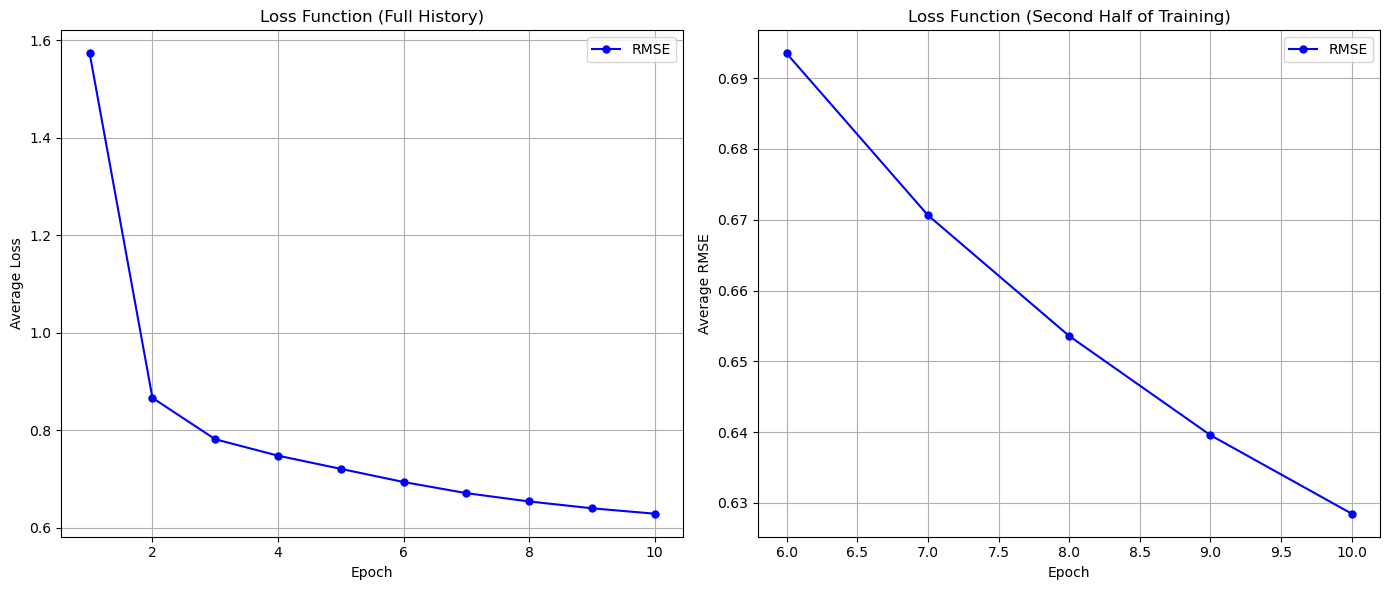

In [11]:
# График обучения
ctdrnn.plot_training_history()

#### Оценка модели

In [12]:
%%time
rmse_real, rmse_imag, predictions = ctdrnn.evaluate()
print(f"Evaluation RMSE (Real): {rmse_real:.6f}")
print(f"Evaluation RMSE (Imaginary): {rmse_imag:.6f}")

Evaluation RMSE (Real): 0.218811
Evaluation RMSE (Imaginary): 0.214764
CPU times: user 16.1 s, sys: 1.36 s, total: 17.4 s
Wall time: 2.2 s


In [13]:
# Сохраним предсказанные значения
ctdrnn.save_prediction(predictions)

Training history saved to history/predictions_train_038c1f16-e4de-469f-a9e4-1d6ae58da37a.csv


#### Сохранение модели после обучения

In [15]:
# Сохранение обученной модели
ctdrnn.save_model_pt()

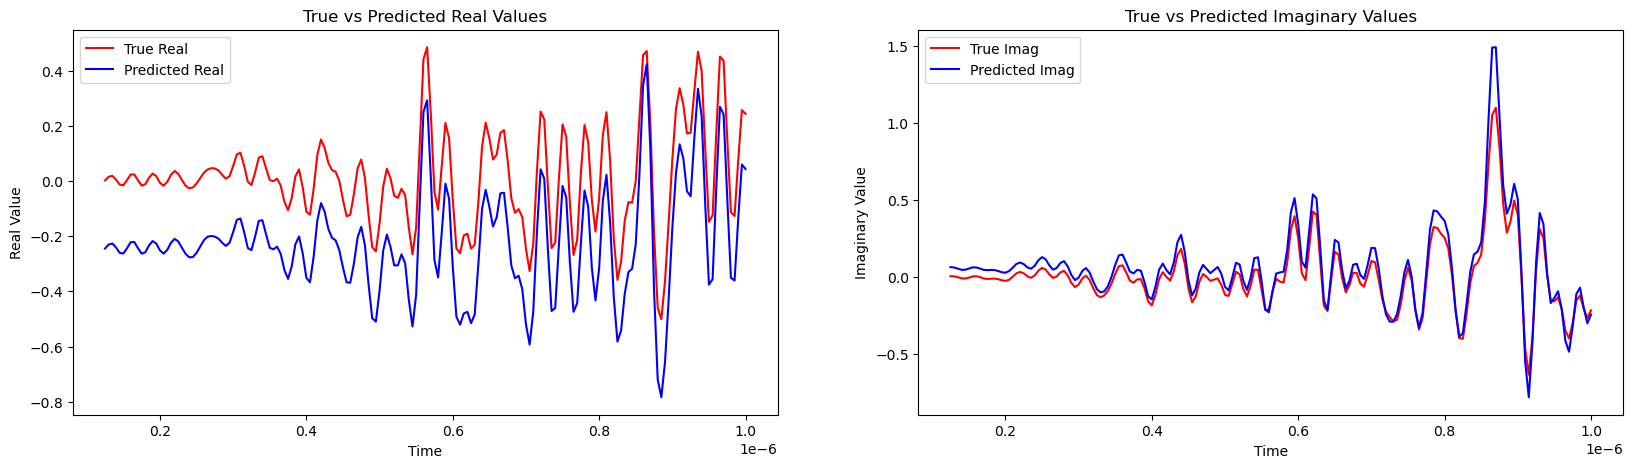

In [16]:
ctdrnn.plot_predictions(time_start=0, time_end=0.1e-5)

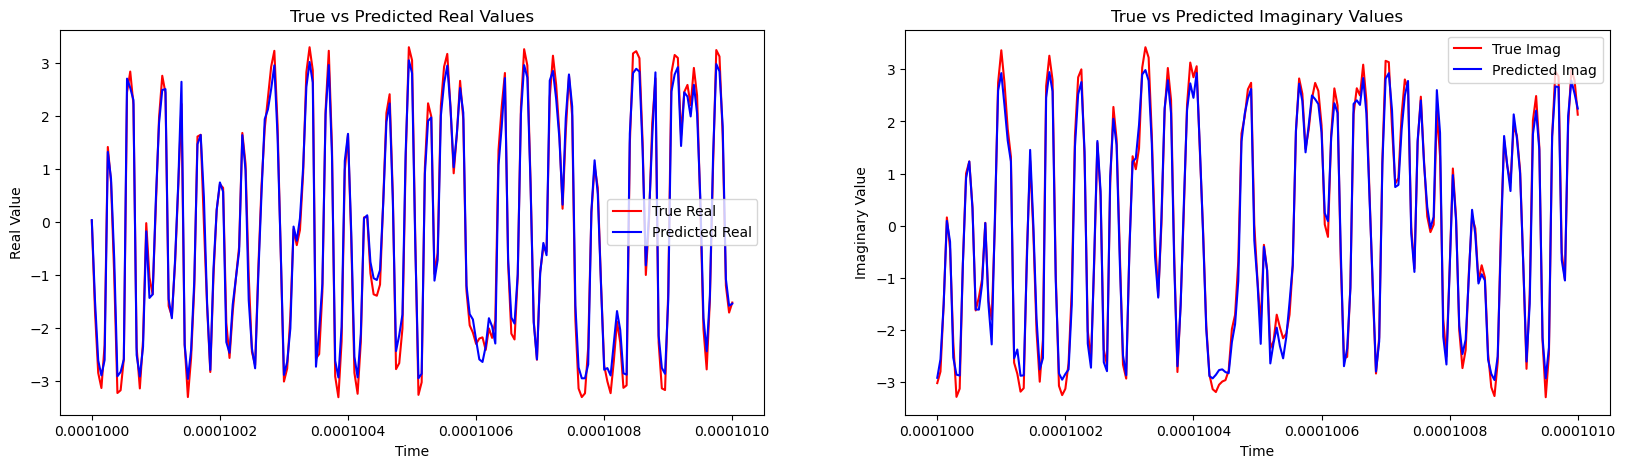

In [17]:
ctdrnn.plot_predictions(time_start=1e-4, time_end=1.01e-4)

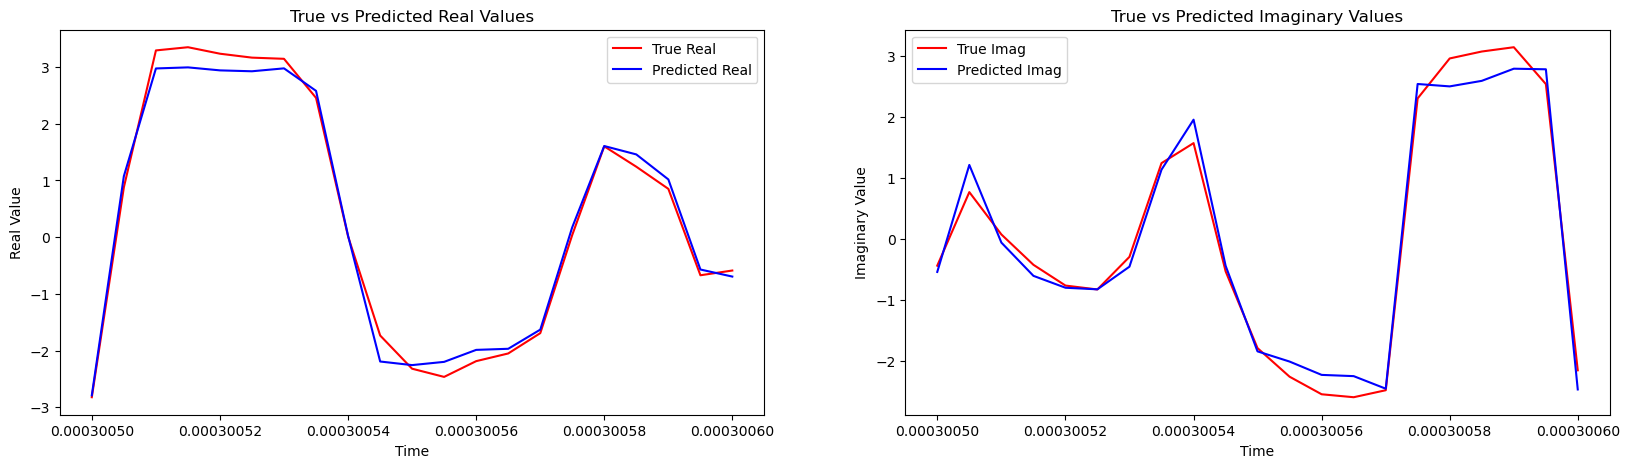

In [18]:
ctdrnn.plot_predictions(time_start=3.005e-4, time_end=3.006e-4)